# Title: Bitcoin Price Prediction using Twitter Sentiment Analysis

#### Team Members : Namitha Chandrabose, Akshay Vijayan

####  Emails : 200522102@student.georgianc.on.ca ,     200520307@student.georgianc.on.ca

### INTRODUCTION:
*********************************************************************************************************************
#### AIM : 
To explore the relationship between a firm's stock price changes and the feelings expressed in tweets about that company. This study attempts to establish the presence of a high association between public attitudes in tweets and changes in stock prices using sentiment analysis and supervised machine learning techniques applied to Twitter data.
*********************************************************************************************************************
#### Github Repo: 
https://github.com/Aaron-Paul/Bitcoin-Price-Twitter-Sentiment-Analysis/tree/main
*********************************************************************************************************************
#### DESCRIPTION OF PAPER:
The research focuses on employing sentiment analysis of Twitter data to predict cryptocurrency price movements. The study explores the relationship between public sentiments expressed on Twitter and the fluctuation of cryptocurrency prices, contributing to the understanding of how social media sentiment can impact financial markets. 
*********************************************************************************************************************
#### PROBLEM STATEMENT :
* Examine the relationship between public mood expressed on Twitter and stock price fluctuations for individual firms.
* Apply sentiment analysis and supervised machine learning techniques to process and analyze tweets, revealing the sentiments associated with individual companies.
* To extract insights from large amounts of social media data, use sophisticated technologies such as Spark ML, Spark-SQL, Hadoop Mapreduce, Pandas, Matplotlib, Scikit-learn, TensorFlow, and Keras.
* Demonstrate the tangible connection between positive news and sentiments shared on social media and the subsequent impact on stock prices, showcasing the potential of sentiment analysis for enhancing stock market prediction.
*********************************************************************************************************************
#### CONTEXT OF THE PROBLEM:
* The research investigates the link between public mood on platforms such as Twitter and stock market movements, with an emphasis on the potential correlation between feelings and stock price fluctuations.
* Utilizing sentiment analysis and supervised machine learning techniques, the study aims to analyze the connection between sentiments expressed in tweets and fluctuations in stock prices.
* In the context of stock market prediction, the project processes and interprets social media attitudes using sophisticated technologies such as Spark ML, Spark-SQL, Hadoop Mapreduce, and different libraries.

*********************************************************************************************************************
#### SOLUTION:
* The proposed approach is a simple sentimental analysis & then forecasting
* We explored the temporal correlations between sentiment data taken from tweets and variations in cryptocurrency stock values using time series analysis techniques.
* We built predictive models to estimate bitcoin price fluctuations based on sentiment analysis of tweets, leveraging the capabilities of sequential models, particularly in the context of neural networks.


# Background
*********************************************************************************************************************
#### In this paper they divided their 'Related Work' into 2 parts :

#### Analyzing Social Media Sentiments for Stock Market Prediction

|Reference|
|-----------------------|
|Colianni, S., Rosales, S. and Signorotti, M., 2015. Algorithmic trading of cryptocurrency based on Twitter sentiment analysis. CS229 Project, 1(5), pp.1-4|


*********************************************************************************************************************
#### Methodological Framework and Correlation Exploration

|Reference|
|------------------------|
|Jain, A., Tripathi, S., Dwivedi, H.D. and Saxena, P., 2018, August. Forecasting price of cryptocurrencies using tweets sentiment analysis. In 2018 eleventh international conference on contemporary computing (IC3) (pp. 1-7). IEEE.
|

*********************************************************************************************************************

# Methodology
*********************************************************************************************************************
#### Basic Details of Keras :
* Keras gives a Sequential API for building and training sequence-based models for time series forecasting applications.
* Keras has recurrent layers like as LSTM (Long Short-Term Memory) and GRU (Gated Recurrent Unit) that are critical for capturing temporal relationships in time series data.
* Keras streamlines the workflow from data preparation to model training by simplifying time series data preprocessing tasks such as sequence padding, input shaping, and feature engineering.




# Implementation

In [3]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import pyspark as spark
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
from pyspark.sql.types import *
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from elephas.utils.rdd_utils import to_simple_rdd
sc = spark.SparkContext()
sql = spark.SQLContext(sc)

In [2]:
pip install elephas

  Using cached keras-2.10.0-py2.py3-none-any.whl (1.7 MB)
  Attempting uninstall: keras
    Found existing installation: keras 2.13.1
    Uninstalling keras-2.13.1:
      Successfully uninstalled keras-2.13.1


# Single Feature Sentiment Analysis

In [4]:
df = pd.read_csv('/content/finals.csv',header=None)
df.columns = ['DateTime','Price']
df.head()

,DateTime,Price
0,2017-10-31T05:00:00.000Z,6158.76
1,2017-10-31T06:00:00.000Z,6105.90
2,2017-10-31T07:00:00.000Z,6094.36
3,2017-10-31T08:00:00.000Z,6125.13
4,2017-10-31T09:00:00.000Z,6165.00


## Plotting the input variables

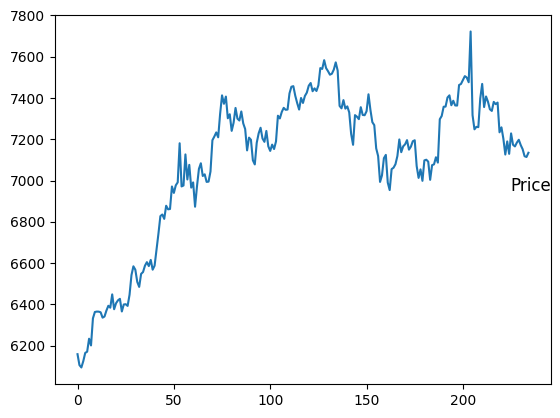

In [6]:
values = df.values
# specify columns to plot
groups = [ 1]
i = 1
# plot each column
plt.figure()
for group in groups:
	plt.subplot(len(groups), 1, i)
	plt.plot(values[:, group])
	plt.title(df.columns[group], y=0.5, loc='right')
	i += 1
plt.show()

Set index to datetime and change the order of columns

In [7]:
df.set_index('DateTime',inplace=True)
cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]
df = df[cols]
df


,Price
DateTime,
2017-10-31T05:00:00.000Z,6158.76
2017-10-31T06:00:00.000Z,6105.90
2017-10-31T07:00:00.000Z,6094.36
2017-10-31T08:00:00.000Z,6125.13
2017-10-31T09:00:00.000Z,6165.00
...,...
2017-11-09T19:00:00.000Z,7171.75
2017-11-09T20:00:00.000Z,7151.72
2017-11-09T21:00:00.000Z,7117.70


In [8]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(df.values)

In [9]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    '''
    Converts the original dataframe to a format which contains
    lag shifted values of inputs which can be used as input
    to the LSTM
    '''
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [10]:
n_hours = 3  #no of time lags
n_features = 1 #no of features
n_obs = n_hours*n_features

In [11]:
reframed = series_to_supervised(scaled, n_hours, 1)
reframed.head()

,var1(t-3),var1(t-2),var1(t-1),var1(t)
3,0.039567,0.007090,0.000000,0.018905
4,0.007090,0.000000,0.018905,0.043401
5,0.000000,0.018905,0.043401,0.046946
6,0.018905,0.043401,0.046946,0.085634
7,0.043401,0.046946,0.085634,0.065537


In [12]:
reframed = reframed.drop(reframed.columns[-1], axis=1)
reframed.head()

,var1(t-3),var1(t-2),var1(t-1)
3,0.039567,0.007090,0.000000
4,0.007090,0.000000,0.018905
5,0.000000,0.018905,0.043401
6,0.018905,0.043401,0.046946
7,0.043401,0.046946,0.085634


In [13]:
values = reframed.values
n_train_hours = 170
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
train.shape

(170, 3)

In [14]:
# split into input and outputs
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]

In [15]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(170, 3, 1) (170,) (62, 3, 1) (62,)


In [16]:
# design network
model = Sequential()
model.add(LSTM(5, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=4, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history


Epoch 1/20
43/43 - 4s - loss: 0.5381 - val_loss: 0.5883 - 4s/epoch - 82ms/step
Epoch 2/20
43/43 - 0s - loss: 0.3627 - val_loss: 0.3574 - 457ms/epoch - 11ms/step
Epoch 3/20
43/43 - 0s - loss: 0.1985 - val_loss: 0.1139 - 193ms/epoch - 4ms/step
Epoch 4/20
43/43 - 0s - loss: 0.1196 - val_loss: 0.0563 - 209ms/epoch - 5ms/step
Epoch 5/20
43/43 - 0s - loss: 0.1207 - val_loss: 0.0550 - 203ms/epoch - 5ms/step
Epoch 6/20
43/43 - 0s - loss: 0.1139 - val_loss: 0.0529 - 185ms/epoch - 4ms/step
Epoch 7/20
43/43 - 0s - loss: 0.1048 - val_loss: 0.0498 - 201ms/epoch - 5ms/step
Epoch 8/20
43/43 - 0s - loss: 0.0972 - val_loss: 0.0473 - 241ms/epoch - 6ms/step
Epoch 9/20
43/43 - 0s - loss: 0.0899 - val_loss: 0.0451 - 212ms/epoch - 5ms/step
Epoch 10/20
43/43 - 0s - loss: 0.0832 - val_loss: 0.0442 - 219ms/epoch - 5ms/step
Epoch 11/20
43/43 - 0s - loss: 0.0764 - val_loss: 0.0428 - 249ms/epoch - 6ms/step
Epoch 12/20
43/43 - 0s - loss: 0.0698 - val_loss: 0.0394 - 315ms/epoch - 7ms/step
Epoch 13/20
43/43 - 0s - l

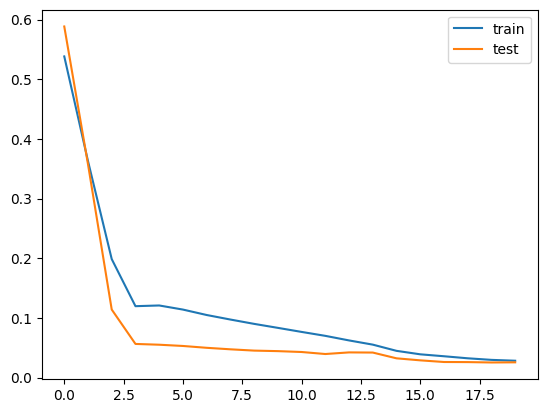

In [17]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [18]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours* n_features))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

2/2 [==============================] - 0s 7ms/step
Test RMSE: 61.387


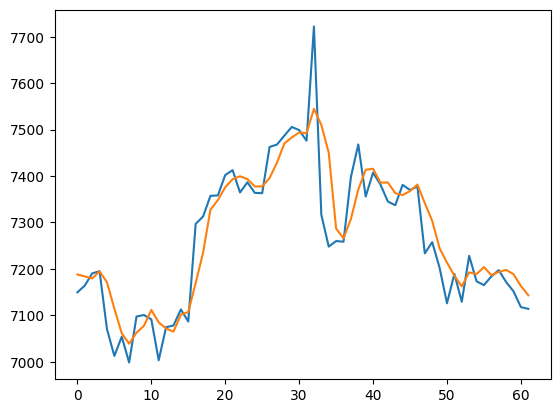

In [19]:
plt.plot(inv_y)
plt.plot(inv_yhat)

In [20]:
plt.show()

In [21]:
inv_y = np.insert(inv_y,0,7000)

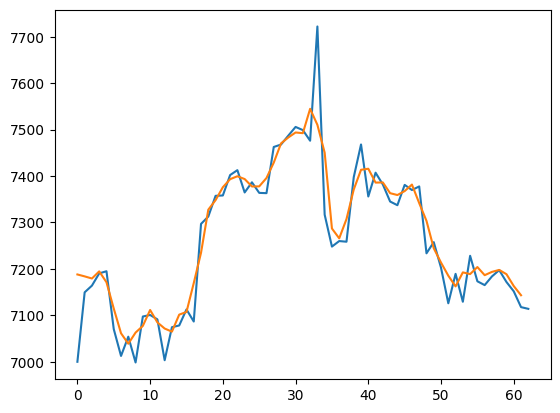

In [22]:
plt.plot(inv_y)
plt.plot(inv_yhat)
plt.show()

In [23]:
df.head()


,Price
DateTime,
2017-10-31T05:00:00.000Z,6158.76
2017-10-31T06:00:00.000Z,6105.90
2017-10-31T07:00:00.000Z,6094.36
2017-10-31T08:00:00.000Z,6125.13
2017-10-31T09:00:00.000Z,6165.00


# Elephas Implementation

In [24]:
# Assuming your DataFrame has the index as "DateTime" and a column named "Price"
spark_df = sql.createDataFrame(df.reset_index())

# Make sure to replace "DateTime" with the actual name of your index column if it's different
CleanDF = spark_df.withColumn("DateTime_casted", spark_df['DateTime'].cast(TimestampType()))

# Select the necessary columns
FinalDf = CleanDF.selectExpr("DateTime_casted as Date_Time", "Price AS Price1")

# Show the updated DataFrame
FinalDf.show()


+-------------------+-------+
|          Date_Time| Price1|
+-------------------+-------+
|2017-10-31 05:00:00|6158.76|
|2017-10-31 06:00:00| 6105.9|
|2017-10-31 07:00:00|6094.36|
|2017-10-31 08:00:00|6125.13|
|2017-10-31 09:00:00| 6165.0|
|2017-10-31 10:00:00|6170.77|
|2017-10-31 11:00:00|6233.74|
|2017-10-31 12:00:00|6201.03|
|2017-10-31 13:00:00|6332.34|
|2017-10-31 14:00:00|6363.13|
|2017-10-31 15:00:00|6365.16|
|2017-10-31 16:00:00|6364.78|
|2017-10-31 17:00:00|6361.79|
|2017-10-31 18:00:00|6335.64|
|2017-10-31 19:00:00|6341.15|
|2017-10-31 20:00:00|6370.08|
|2017-10-31 21:00:00|6393.26|
|2017-10-31 22:00:00|6383.94|
|2017-10-31 23:00:00|6448.36|
|2017-11-01 00:00:00|6376.49|
+-------------------+-------+
only showing top 20 rows



In [28]:
from pyspark.sql.functions import lag, col
from pyspark.sql.window import Window
for i in range(2,3):
    col1 = "Price%d"%(i-1)
    col2 = "Price%d"%i
    w = Window().partitionBy().orderBy(col("Date_Time"))
    FinalDf=FinalDf.select("*", lag(col1).over(w).alias(col2)).na.drop()
    FinalDf.show()

+-------------------+-------+-------+
|          Date_Time| Price1| Price2|
+-------------------+-------+-------+
|2017-10-31 06:00:00| 6105.9|6158.76|
|2017-10-31 07:00:00|6094.36| 6105.9|
|2017-10-31 08:00:00|6125.13|6094.36|
|2017-10-31 09:00:00| 6165.0|6125.13|
|2017-10-31 10:00:00|6170.77| 6165.0|
|2017-10-31 11:00:00|6233.74|6170.77|
|2017-10-31 12:00:00|6201.03|6233.74|
|2017-10-31 13:00:00|6332.34|6201.03|
|2017-10-31 14:00:00|6363.13|6332.34|
|2017-10-31 15:00:00|6365.16|6363.13|
|2017-10-31 16:00:00|6364.78|6365.16|
|2017-10-31 17:00:00|6361.79|6364.78|
|2017-10-31 18:00:00|6335.64|6361.79|
|2017-10-31 19:00:00|6341.15|6335.64|
|2017-10-31 20:00:00|6370.08|6341.15|
|2017-10-31 21:00:00|6393.26|6370.08|
|2017-10-31 22:00:00|6383.94|6393.26|
|2017-10-31 23:00:00|6448.36|6383.94|
|2017-11-01 00:00:00|6376.49|6448.36|
|2017-11-01 01:00:00|6405.67|6376.49|
+-------------------+-------+-------+
only showing top 20 rows



In [30]:
FinalDf = FinalDf.selectExpr('Date_Time','Price2 as Input_price','Price1 as Price')

In [31]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))

In [32]:
rdd = to_simple_rdd(sc, train_X, train_y)

In [33]:
rdd.count()

170

In [62]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD
#from keras.models import model_from_yaml,slice_X
import torch.optim as optim
import torch
import torch.nn as nn

In [57]:
from keras.utils import np_utils
from elephas.spark_model import SparkModel
from elephas.utils.rdd_utils import to_simple_rdd
from tensorflow.keras.optimizers import Adam

In [64]:
# Create a sequential model
model = nn.Sequential(
    nn.Linear(784, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 10),
    nn.Softmax(dim=1)
)

In [67]:
# Define the Adam optimizer and provide model parameters
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [96]:
# Convert the DataFrame to a format suitable for training
features_array = FinalDf.select("Input_price").rdd.map(lambda row: np.array(row)).collect()
labels_array = FinalDf.select("Price").rdd.map(lambda row: np.array(row)).collect()

# Create a sequential Keras model
keras_model = Sequential([
    Dense(128, input_shape=(1,), activation='relu'),  # Adjust input shape according to your feature dimensions
    Dense(64, activation='relu'),
    Dense(1, activation='linear')  # Assuming a regression task
])

# Compile the Keras model
keras_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])

# Convert your NumPy arrays to RDD format
data_rdd = sc.parallelize(zip(features_array, labels_array))

# Initialize SparkModel
spark_model = SparkModel(keras_model, frequency='epoch', mode='synchronous', num_workers=2)

# Train the SparkModel
# Train the Keras model within the SparkModel object
spark_model.fit(data_rdd, epochs=50, batch_size=4, verbose=2, validation_split=0.1)


>>> Fit model
>>> Synchronous training complete.


## Multifeature Sentiment Analysis

In [97]:
df1 = pd.read_csv('/content/results.csv',header=None)
df1.columns = ['DateTime','Negative','Neutral','Positive','Compound','Price']
df1.head()

,DateTime,Negative,Neutral,Positive,Compound,Price
0,2017-10-31T05:00:00.000Z,0.028693,0.893468,0.075036,0.098252,6158.76
1,2017-10-31T06:00:00.000Z,0.033298,0.866806,0.099268,0.133432,6105.90
2,2017-10-31T07:00:00.000Z,0.032960,0.868896,0.096757,0.129065,6094.36
3,2017-10-31T08:00:00.000Z,0.032679,0.884061,0.083261,0.112910,6125.13
4,2017-10-31T09:00:00.000Z,0.035034,0.868187,0.096220,0.130149,6165.00


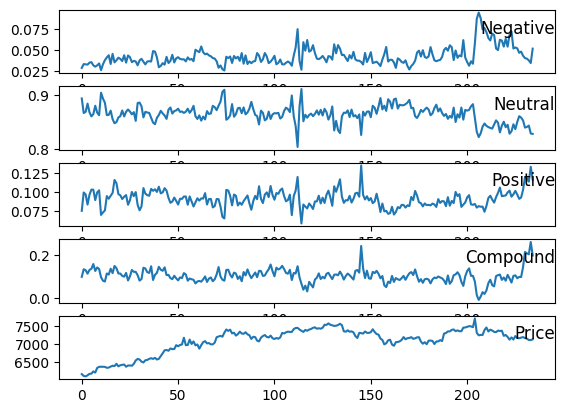

In [98]:
values = df1.values
# specify columns to plot
groups = [ 1,2,3,4,5]
i = 1
# plot each column
plt.figure()
for group in groups:
	plt.subplot(len(groups), 1, i)
	plt.plot(values[:, group])
	plt.title(df1.columns[group], y=0.5, loc='right')
	i += 1
plt.show()

In [99]:
df1.set_index('DateTime',inplace=True)

In [100]:
cols = df1.columns.tolist()
cols = cols[-1:] + cols[:-1]
df1 = df1[cols]
df1.head()

,Price,Negative,Neutral,Positive,Compound
DateTime,,,,,
2017-10-31T05:00:00.000Z,6158.76,0.028693,0.893468,0.075036,0.098252
2017-10-31T06:00:00.000Z,6105.90,0.033298,0.866806,0.099268,0.133432
2017-10-31T07:00:00.000Z,6094.36,0.032960,0.868896,0.096757,0.129065
2017-10-31T08:00:00.000Z,6125.13,0.032679,0.884061,0.083261,0.112910
2017-10-31T09:00:00.000Z,6165.00,0.035034,0.868187,0.096220,0.130149


In [101]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(df1.values)

In [102]:
n_hours = 3
n_features = 5
n_obs = n_hours*n_features

In [103]:
reframed = series_to_supervised(scaled, n_hours, 1)
reframed.head()

,var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t),var2(t),var3(t),var4(t),var5(t)
3,0.039567,0.044729,0.837460,0.218348,0.398397,0.007090,0.110680,0.586224,0.534241,0.529760,0.000000,0.105840,0.605920,0.501513,0.513454,0.018905,0.101818,0.748817,0.325570,0.453129
4,0.007090,0.110680,0.586224,0.534241,0.529760,0.000000,0.105840,0.605920,0.501513,0.513454,0.018905,0.101818,0.748817,0.325570,0.453129,0.043401,0.135554,0.599233,0.494515,0.517499
5,0.000000,0.105840,0.605920,0.501513,0.513454,0.018905,0.101818,0.748817,0.325570,0.453129,0.043401,0.135554,0.599233,0.494515,0.517499,0.046946,0.144279,0.528585,0.584308,0.538178
6,0.018905,0.101818,0.748817,0.325570,0.453129,0.043401,0.135554,0.599233,0.494515,0.517499,0.046946,0.144279,0.528585,0.584308,0.538178,0.085634,0.089063,0.566914,0.582236,0.619100
7,0.043401,0.135554,0.599233,0.494515,0.517499,0.046946,0.144279,0.528585,0.584308,0.538178,0.085634,0.089063,0.566914,0.582236,0.619100,0.065537,0.066399,0.712071,0.402359,0.499534


In [104]:
reframed = reframed.drop(reframed.columns[-4:], axis=1)
reframed.head()

,var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t)
3,0.039567,0.044729,0.837460,0.218348,0.398397,0.007090,0.110680,0.586224,0.534241,0.529760,0.000000,0.105840,0.605920,0.501513,0.513454,0.018905
4,0.007090,0.110680,0.586224,0.534241,0.529760,0.000000,0.105840,0.605920,0.501513,0.513454,0.018905,0.101818,0.748817,0.325570,0.453129,0.043401
5,0.000000,0.105840,0.605920,0.501513,0.513454,0.018905,0.101818,0.748817,0.325570,0.453129,0.043401,0.135554,0.599233,0.494515,0.517499,0.046946
6,0.018905,0.101818,0.748817,0.325570,0.453129,0.043401,0.135554,0.599233,0.494515,0.517499,0.046946,0.144279,0.528585,0.584308,0.538178,0.085634
7,0.043401,0.135554,0.599233,0.494515,0.517499,0.046946,0.144279,0.528585,0.584308,0.538178,0.085634,0.089063,0.566914,0.582236,0.619100,0.065537


In [105]:
values = reframed.values
n_train_hours = 170
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
train.shape

(170, 16)

In [106]:
# split into input and outputs
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]

In [107]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(170, 3, 5) (170,) (62, 3, 5) (62,)


In [108]:
# design network
model = Sequential()
model.add(LSTM(5, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=4, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history

Epoch 1/20
43/43 - 5s - loss: 0.2181 - val_loss: 0.2956 - 5s/epoch - 116ms/step
Epoch 2/20
43/43 - 0s - loss: 0.0887 - val_loss: 0.2209 - 276ms/epoch - 6ms/step
Epoch 3/20
43/43 - 0s - loss: 0.0866 - val_loss: 0.2219 - 249ms/epoch - 6ms/step
Epoch 4/20
43/43 - 0s - loss: 0.0831 - val_loss: 0.2137 - 254ms/epoch - 6ms/step
Epoch 5/20
43/43 - 0s - loss: 0.0807 - val_loss: 0.2058 - 239ms/epoch - 6ms/step
Epoch 6/20
43/43 - 0s - loss: 0.0785 - val_loss: 0.1978 - 463ms/epoch - 11ms/step
Epoch 7/20
43/43 - 0s - loss: 0.0766 - val_loss: 0.1913 - 446ms/epoch - 10ms/step
Epoch 8/20
43/43 - 1s - loss: 0.0743 - val_loss: 0.1863 - 596ms/epoch - 14ms/step
Epoch 9/20
43/43 - 1s - loss: 0.0724 - val_loss: 0.1803 - 587ms/epoch - 14ms/step
Epoch 10/20
43/43 - 1s - loss: 0.0706 - val_loss: 0.1734 - 588ms/epoch - 14ms/step
Epoch 11/20
43/43 - 1s - loss: 0.0688 - val_loss: 0.1682 - 643ms/epoch - 15ms/step
Epoch 12/20
43/43 - 1s - loss: 0.0671 - val_loss: 0.1613 - 714ms/epoch - 17ms/step
Epoch 13/20
43/43 -

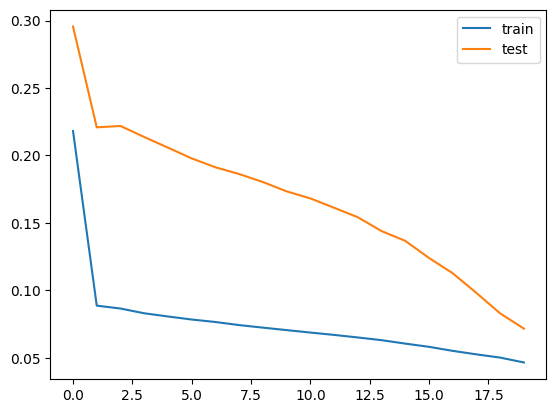

In [109]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [110]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours* n_features))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -4:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -4:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

2/2 [==============================] - 1s 10ms/step
Test RMSE: 172.035


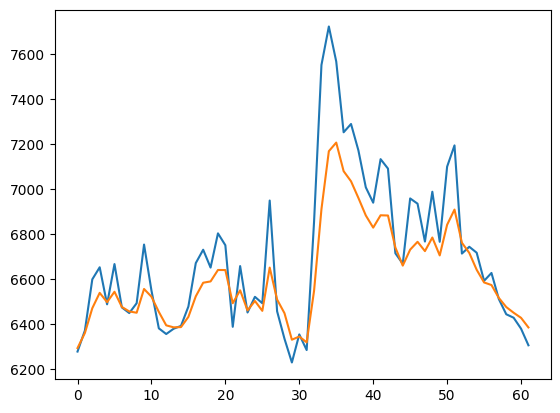

In [111]:
plt.plot(inv_y)
plt.plot(inv_yhat)

In [112]:
plt.show()

In [113]:
df_sol = pd.DataFrame({'forecast':inv_yhat,'actual':inv_y})
df_sol.to_csv('Predictions_nosent.csv')

*********************************************************************************************************************
### My Additions in the Project :
* Analysed the model with different sized datasets
* Fixed multiple errors in the code
* Elephas Distributed hyper-parameter optimization (removed as of 3.0.0) was an important stage in the project. So instead of that used keras optimizer.

### Conclusion and Future Direction :
*******************************************************************************************************************************
#### Learnings : 
Finally, the research presented here looks towards forecasting Bitcoin price swings using sentiment analysis of Twitter data. The study highlights the potential effect of public sentiments on financial markets by investigating the link between social media sentiment and cryptocurrency price fluctuations. The study effectively establishes a link between feelings stated on Twitter and subsequent fluctuations in Bitcoin values using advanced techniques such as Spark ML and LSTM neural networks. This demonstrates the utility of sentiment analysis as a technique for improving stock market forecasting, paving the way for additional research into the dynamic interplay between social media and financial markets.
 
*******************************************************************************************************************************
#### Results Discussion :
The study's findings show a significant link between Twitter mood and Bitcoin price changes. The study validates the possibility of sentiment analysis for predicting cryptocurrency price movements by utilising modern machine learning techniques such as Spark ML and LSTM neural networks, highlighting the significance of social media data in financial analysis.


*******************************************************************************************************************************
#### Limitations :
* The study's findings are dependent on the quality of Twitter data, which may contain noise, sarcasm, and figurative language, thus reducing sentiment accuracy.

* Market Dependence: Cryptocurrency markets are extremely volatile and can be impacted by a variety of uncontrollable events, possibly influencing the link between emotion and price.

* Sentiment Complexity: Cryptocurrency sentiment is complex because it may fluctuate quickly owing to breaking news, regulatory developments, and market rumours, which are not fully reflected by previous data.

* Overreliance on Twitter: Relying entirely on Twitter sentiment may oversimplify the complex process of determining bitcoin prices, ignoring other important market considerations.



*******************************************************************************************************************************
#### Future Extension :
Future study might look into the influence of sentiment on cryptocurrency prices with greater granularity by taking into account numerous external factors, extending to a wider spectrum of cryptocurrencies, and including sentiment from other online sources. This may result in a better understanding of the bitcoin market and its relationship to the larger financial environment.


# References:

[1]:  Baur, D.G., Dimpfl, T. The volatility of Bitcoin and its role as a medium of exchange and a store of
value. Empir Econ 61, 2663–2683 (2021).

[2]:  Dimitrios Bakas, Georgios Magkonis, Eun Young Oh, What drives volatility in Bitcoin market?,
Finance Research Letters, Volume 50, 2022, 103237, ISSN 1544-6123,

[3]: Pano, Toni, and Rasha Kashef. "A complete VADER-based sentiment analysis of bitcoin (BTC)
tweets during the era of COVID-19." Big Data and Cognitive Computing 4, no. 4 (2020): 33.

[4]: Wu, Chih-Hung, Chih-Chiang Lu, Yu-Feng Ma, and Ruei-Shan Lu. "A new forecasting framework
for bitcoin price with LSTM." In 2018 IEEE International Conference on Data Mining Workshops
(ICDMW), pp. 168-175. IEEE, 2018

[5]: Patel, Mohil Maheshkumar, Sudeep Tanwar, Rajesh Gupta, and Neeraj Kumar. "A deep learningbased cryptocurrency price prediction scheme for financial institutions." Journal of information
security and applications 55 (2020): 102583.

[6]: Jain, A., Tripathi, S., Dwivedi, H.D. and Saxena, P., 2018, August. Forecasting price of
cryptocurrencies using tweets sentiment analysis. In 2018 eleventh international conference on
contemporary computing (IC3) (pp. 1-7). IEEE.

[7]: ] Devavrat Shah and Kang Zhang Bayesian regression and Bitcoin


[8]: Zhengyao Jiang and Jinjun Liang Cryptocurrency Portfolio Management with Deep Reinforcement
Learning 

[9]: Hutto, C. and Gilbert, E., 2014, May. Vader: A parsimonious rule-based model for sentiment analysis
of social media text. In Proceedings of the international AAAI conference on web and social media
(Vol. 8, No. 1, pp. 216-225).

[10] : M.E.Peters, M.Neumann, M.Iyyer, M.Gardner,C.Clark,K.Lee,and L. Zettlemoyer, “Deep
contextualized word representations,” in Proc. of NAACL, 2018